# Post prediction analysis
This file mimics what 08-1_threshold_adj.Rmd does to look at several cases that were not included in training and testing. 
I would like to 
1. compare the python model predictions to those of the real Evaluation 
2. compare the python model predictions to those of the R model predictions

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


In [ ]:
# Define directories
project_dir = Path("/Users/Jennie/Desktop/WashU/Rotation_labs/Griffith Lab/Neoantigen ML project")
pred_dir = project_dir / "output_python" / "08_randomForest_predict.py"
eval_dir = project_dir / "data" / "itb_review_new"
r_pred_dir = project_dir / "output" / "08_randomForest_predict.Rmd"
outdir = project_dir / "output_python" / "08-1_threshold_adj.ipynb"
os.makedirs(outdir, exist_ok=True)


In [ ]:
# List of patient IDs
#fnames = ["5120-16", "5120-17", "5120-18", "5120-19"]
fnames_new = ["5120-16", "5120-17", "5120-18", "5120-19", "5120-39", "CTEP-10146-MD017-0052", "G110_Region1", "G110_Region2", "G113_Region1"]


Explanation
1. Merge Python Model Predictions with Real Evaluation Data:

The `merge_pred_eval` function merges the Python model predictions with the real Evaluation data.
The merged data is saved to a file and returned as a DataFrame.

2. Merge Python Model Predictions with R Model Predictions:

The `merge_pred_rmodel` function merges the Python model predictions with the R model predictions.
The merged data is saved to a file and returned as a DataFrame.

3. Evaluate the Predictions:

The `evaluate_predictions` function evaluates the Python model predictions against the real Evaluation data using confusion matrices and classification reports.
The evaluate_python_vs_r function evaluates the Python model predictions against the R model predictions using confusion matrices and classification reports.
This code mimics the functionality of the 08-1_threshold_adj.Rmd file and provides a comprehensive evaluation of the Python model predictions.

In [ ]:
# Function to merge Python and R predictions with evaluation data
def merge_python_r_predictions(patient_id, pred_dir, eval_dir, r_pred_dir, outdir):
    # Locate and read Python prediction file
    predict_files = list(pred_dir.glob(f"*{patient_id}*_newThreshold2*.tsv"))
    if not predict_files:
        raise FileNotFoundError(f"No Python prediction file found for patient: {patient_id}")
    predict_file = pd.read_csv(predict_files[0], sep="\t")
    
    # Rename Python prediction columns
    predict_file = predict_file.rename(columns={
        "Evaluation_pred": "python_Evaluation_pred",
        "Accept_pred_prob": "python_Accept_pred_prob"
    })
    
    # Locate and read evaluation file
    eval_files = list(eval_dir.glob(f"*{patient_id}*.tsv"))
    if not eval_files:
        raise FileNotFoundError(f"No evaluation file found for patient: {patient_id}")
    eval_file = pd.read_csv(eval_files[0], sep="\t")
    
    # Merge Python predictions with evaluation data
    merged_df_export = pd.merge(predict_file, eval_file[['ID', 'Evaluation']], on="ID")
    
    # Locate and read R prediction file
    r_predict_files = list(r_pred_dir.glob(f"*{patient_id}*_newThreshold2.tsv"))
    if not r_predict_files:
        raise FileNotFoundError(f"No R prediction file found for patient: {patient_id}")
    r_predict_file = pd.read_csv(r_predict_files[0], sep="\t")
    
    # Select and rename R prediction columns
    r_predict_file = r_predict_file.rename(columns={
        "Evaluation_pred": "R_Evaluation_pred",
        "Accept_pred_prob": "R_Accept_pred_prob"
    })[['ID', 'R_Evaluation_pred', 'R_Accept_pred_prob']]
    
    # Merge R predictions with the existing merged dataframe
    final_merged_df = pd.merge(merged_df_export, r_predict_file, on="ID", how="left")
    
    # Export the final merged dataframe as a TSV file
    out_name = f"{patient_id}_merged_python_R_predictions.tsv"
    final_merged_df.to_csv(outdir / out_name, sep="\t", index=False)
    
    return final_merged_df

# Example usage for debugging and testing
# final_df = merge_python_r_predictions("5120-16", pred_dir, eval_dir, r_pred_dir, outdir)

all_files_python_R = [merge_python_r_predictions(pid, pred_dir, eval_dir, r_pred_dir, outdir) for pid in fnames_new]

# Identify common columns among all dataframes
common_cols = set.intersection(*(set(df.columns) for df in all_files_python_R))
common_cols = list(common_cols)  # Convert the set to a list

# Subset each DataFrame to only include the common columns
all_files_python_R = [df[common_cols] for df in all_files_python_R]

# Merge all dataframes by binding rows
all_df_python_R = pd.concat(all_files_python_R, ignore_index=True)

# Export the combined data frame
all_df_python_R.to_excel(outdir / "eval_compare_python_R.xlsx", index=False)


After merging python predictions to the actual Evaluations make confusion matrix: 

In [ ]:
# Change "Pending" in Evaluation to "Reject"
all_df_python_R['Evaluation'] = all_df_python_R['Evaluation'].replace("Pending", "Reject")

# Remove rows where Evaluation_pred is "Pending"
#all_df_eval = all_df_python_R[all_df_python_R['Evaluation_pred'] != "Pending"]

# Ensure the columns are categorical (similar to factors in R)
all_df_python_R['Evaluation'] = all_df_python_R['Evaluation'].astype('category')
all_df_python_R['python_Evaluation_pred'] = all_df_python_R['python_Evaluation_pred'].astype('category')
all_df_python_R['R_Evaluation_pred'] = all_df_python_R['R_Evaluation_pred'].astype('category')


# Compare results

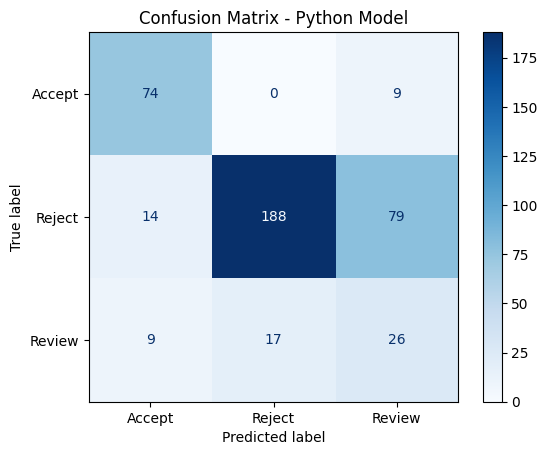

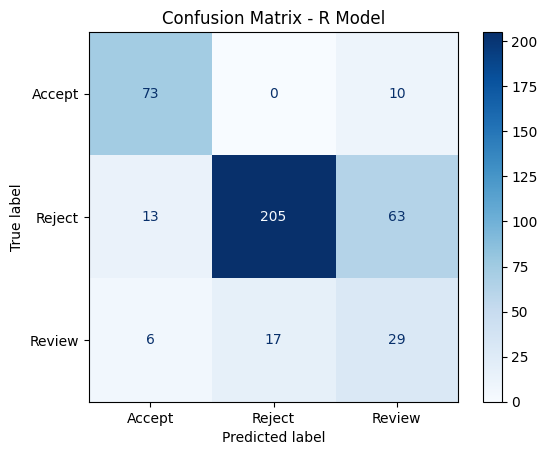

In [ ]:
# Confusion matrix for Python model
python_conf_matrix = confusion_matrix(all_df_python_R['Evaluation'], all_df_python_R['python_Evaluation_pred'])
disp_python = ConfusionMatrixDisplay(confusion_matrix=python_conf_matrix, display_labels=all_df_python_R['Evaluation'].unique())
disp_python.plot(cmap='Blues')
plt.title("Confusion Matrix - Python Model")
plt.show()

# Confusion matrix for R model
r_conf_matrix = confusion_matrix(all_df_python_R['Evaluation'], all_df_python_R['R_Evaluation_pred'])
disp_r = ConfusionMatrixDisplay(confusion_matrix=r_conf_matrix, display_labels=all_df_python_R['Evaluation'].unique())
disp_r.plot(cmap='Blues')
plt.title("Confusion Matrix - R Model")
plt.show()


Evaluate predictions